In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [4]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

# TITLE

Little text to explain main idea

## 1) Loading data and basic analysis

Could contain, how many rows, columns, missing values, etc.

### Data cleaning

Drop fill missing values, etc.

In [5]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

## User dataframe (The user dataframe are similar for both platforms)

In [6]:
users_df_ba.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland




1. **nbr_ratings**: Number of beer ratings by users.
2. **nbr_reviews**: Count of beer reviews submitted.
3. **user_id**: Unique identifier for users.
4. **user_name**: Usernames associated with users.
5. **joined**: Date when users joined the platform.
6. **location**: Geographical location of users.

## Breweries dataframe

In [7]:
breweries_df.head()

,brewery_id_ba,brewery_location_ba,brewery_name_ba,brewery_nbr_beers_ba,brewery_id_rb,brewery_nbr_beers_rb
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,5
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,2
2,40360,Northern Ireland,Walled City Brewing Company,6,24866,3
3,40309,Northern Ireland,Ards Brewing Company,7,13538,13
4,41205,Northern Ireland,Barrahooley Brewery,3,22304,4


1. **brewery_id_ba**: Unique identifier for breweries on BeerAdvocate.
2. **brewery_location_ba**: Geographical location of breweries on BeerAdvocate.
3. **brewery_name_ba**: Names of breweries on BeerAdvocate.
4. **brewery_nbr_beers_ba**: Number of beers associated with each brewery on BeerAdvocate.
5. **brewery_id_rb**: Unique identifier for breweries on RateBeer.
6. **brewery_nbr_beers_rb**: Number of beers associated with each brewery on RateBeer.

## Beers dataframe (enriched with data from breweries dataframe)

- The rows contain the different beers rated on the two platforms

In [8]:
beers_df.head()

,abv_ba,beer_avg_rating_ba,beer_id_ba,beer_name_ba,brewery_id_ba,nbr_ratings_ba,style_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location_ba,brewery_name_ba,brewery_nbr_beers_ba,brewery_nbr_beers_rb
0,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
1,6.0,3.888750,20841,St. Patrick's Ale,10093,8,English Pale Ale,3.290909,41286,4959,11,3.542632,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
2,4.2,3.556094,20842,St. Patrick's Best,10093,64,English Bitter,2.831081,41287,4959,74,3.167319,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
3,4.8,3.960000,22659,St. Patrick's Gold,10093,1,American Pale Wheat Ale,2.775000,41285,4959,4,3.012000,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5
4,4.5,NaN,178681,Sheelin Stout,32848,0,Irish Dry Stout,3.200000,230283,17616,2,NaN,Northern Ireland,The Sheelin Brewery,4,2


1. **abv_ba**: Alcohol by volume for beers on BeerAdvocate.
2. **beer_avg_rating_ba**: Average rating for beers on BeerAdvocate.
3. **beer_id_ba**: Unique identifier for beers on BeerAdvocate.
4. **beer_name_ba**: Names of beers on BeerAdvocate.
5. **brewery_id_ba**: Unique identifier for breweries associated with BeerAdvocate.
6. **nbr_ratings_ba**: Number of ratings for beers on BeerAdvocate.
7. **style_ba**: Beer style on BeerAdvocate.
8. **beer_avg_rating_rb**: Average rating for beers on RateBeer.
9. **beer_id_rb**: Unique identifier for beers on RateBeer.
10. **brewery_id_rb**: Unique identifier for breweries associated with RateBeer.
11. **nbr_ratings_rb**: Number of ratings for beers on RateBeer.
12. **beer_avg_rating_ba_rb**: Average rating for beers on both BeerAdvocate and RateBeer.
13. **brewery_location_ba**: Geographical location of breweries on BeerAdvocate.
14. **brewery_name_ba**: Names of breweries on BeerAdvocate.
15. **brewery_nbr_beers_ba**: Number of beers associated with each brewery on BeerAdvocate.
16. **brewery_nbr_beers_rb**: Number of beers associated with each brewery on RateBeer.

## Complete reviews dataframe

In [9]:
reviews_df.head()

,beer_name,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,...,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings
0,Legbiter,19827,English Pale Ale,1417431600,Hellpop65,hellpop65.48993,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",2326.0
1,Legbiter,19827,English Pale Ale,1401357600,Latarnik,latarnik.52897,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, New Jersey",3098.0
2,Legbiter,19827,English Pale Ale,1393412400,RochefortChris,rochefortchris.697017,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, North Carolina",1866.0
3,Legbiter,19827,English Pale Ale,1392030000,OKCNittany,okcnittany.144868,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Oklahoma",1131.0
4,Legbiter,19827,English Pale Ale,1390647600,jaydoc,jaydoc.265507,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",9987.0


1. **beer_name**: Name of the rated beer.
2. **beer_id**: Unique identifier for the rated beer.
3. **style**: Style of the rated beer.
4. **date**: Date of the rated review.
5. **user_name**: Name of the user providing the rated review.
6. **user_id**: Unique identifier for the user.
7. **appearance**: Rating for the appearance of the rated beer.
8. **aroma**: Rating for the aroma of the rated beer.
9. **palate**: Rating for the palate of the rated beer.
10. **taste**: Rating for the taste of the rated beer.
11. **overall**: Overall rating for the rated beer.
12. **rating**: Another rating associated with the rated beer.
13. **text**: Textual content of the rated review.
14. **review**: Another aspect of the rated review.
15. **abv**: Alcohol by volume for the rated beer.
16. **beer_avg_rating_ba**: Average rating for the rated beer on BeerAdvocate.
17. **beer_id_ba**: Unique identifier for the rated beer on BeerAdvocate.
18. **brewery_id_ba**: Unique identifier for the brewery associated with the rated beer on BeerAdvocate.
19. **nbr_ratings_ba**: Number of ratings for the rated beer on BeerAdvocate.
20. **beer_avg_rating_rb**: Average rating for the rated beer on RateBeer.
21. **beer_id_rb**: Unique identifier for the rated beer on RateBeer.
22. **brewery_id_rb**: Unique identifier for the brewery associated with the rated beer on RateBeer.
23. **nbr_ratings_rb**: Number of ratings for the rated beer on RateBeer.
24. **beer_avg_rating_ba_rb**: Average rating for the rated beer on both BeerAdvocate and RateBeer.
25. **brewery_location**: Geographical location of the brewery associated with the rated beer.
26. **brewery_name**: Name of the brewery associated with the rated beer.
27. **brewery_nbr_beers_ba**: Number of beers associated with the brewery of the rated beer on BeerAdvocate.
28. **brewery_nbr_beers_rb**: Number of beers associated with the brewery of the rated beer on RateBeer.
29. **user_location**: Geographical location of the user.
30. **user_nbr_ratings**: Number of ratings provided by the user.

## 2) First analysis : how beers from one country are rated (reviewed)

### Data cleaning

Remove any beers with < 10 reviews, then aggregate by country, then remove any countries with < 10 beers

### Analysis

Compute some averages for countries, plot them, say there are some diff so we want to investigate

Also do wordclouds for each country using the adjective datasets

Discuss the climate map, how it could be used but only if time allows it

In [10]:
# Copy the dataset to avoid modifying the original
country_ratings = reviews_df.copy()

# Compute amount of reviews per beer by summing nbr_ratings_rb and nbr_ratings_ba
# -------------------------
# POTENTIELLEMENT DEJA FAIT DANS LES LOADING SI ALBAN A CHANGE LE CODE
# AUQUEL CAS MODIFIER LES 2 LIGNES SUIVANTES
# -------------------------

initial_len = len(country_ratings)
print("Number of unique beers initially: ", len(country_ratings["beer_id"].unique()))

country_ratings["nbr_ratings"] = country_ratings["nbr_ratings_rb"] + country_ratings["nbr_ratings_ba"]
# Keep the reviews only for beers with at least 10 reviews
country_ratings = country_ratings[country_ratings["nbr_ratings"] >= 10]

print("Number of unique beers after filtering: ", len(country_ratings["beer_id"].unique()))

Number of unique beers initially:  79628
Number of unique beers after filtering:  42665


In [11]:
# We will now compute for each location the number of beer reviewed
num_unique_beers = country_ratings.groupby("brewery_location")["beer_id"].nunique()
num_unique_beers = num_unique_beers.to_frame().reset_index()
num_unique_beers.columns = ["brewery_location", "num_unique_beers"]

print("Number of countries initially: ", len(country_ratings["brewery_location"].unique()))

# Keep only the countries with at least 10 unique beers
country_ratings = country_ratings.merge(num_unique_beers, on="brewery_location")
country_ratings = country_ratings[country_ratings["num_unique_beers"] >= 10]

print("Number of countries after filtering: ", len(country_ratings["brewery_location"].unique()))
final_len = len(country_ratings)

Number of countries initially:  151
Number of countries after filtering:  109


In [12]:
print('Initial number of reviews: ', initial_len)
print('Final number of reviews: ', final_len)
print('Percentage of reviews kept: {:.2f}%'.format(final_len / initial_len * 100))

Initial number of reviews:  1976606
Final number of reviews:  1878458
Percentage of reviews kept: 95.03%


In [13]:
# Convert the rating column to float
country_ratings["rating"] = country_ratings["rating"].astype(float)

filtered_country_ratings = country_ratings.copy()
# Replace the country names by the official names
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("United States"), "brewery_location"] = "United States of America"

filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("England"), "brewery_location"] = "United Kingdom"
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("Scotland"), "brewery_location"] = "United Kingdom"
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("Wales"), "brewery_location"] = "United Kingdom"
filtered_country_ratings.loc[filtered_country_ratings["brewery_location"].str.contains("Northern Ireland"), "brewery_location"] = "United Kingdom"

# For each country compute the average rating
avg_ratings = filtered_country_ratings.groupby("brewery_location")["rating"].mean()
avg_ratings = avg_ratings.to_frame().reset_index()
avg_ratings.columns = ["brewery_location", "avg_rating"]

avg_ratings.head()

,brewery_location,avg_rating
0,Argentina,3.252430
1,Australia,3.274803
2,Austria,3.309164
3,Bahamas,2.727022
4,Belgium,3.741002


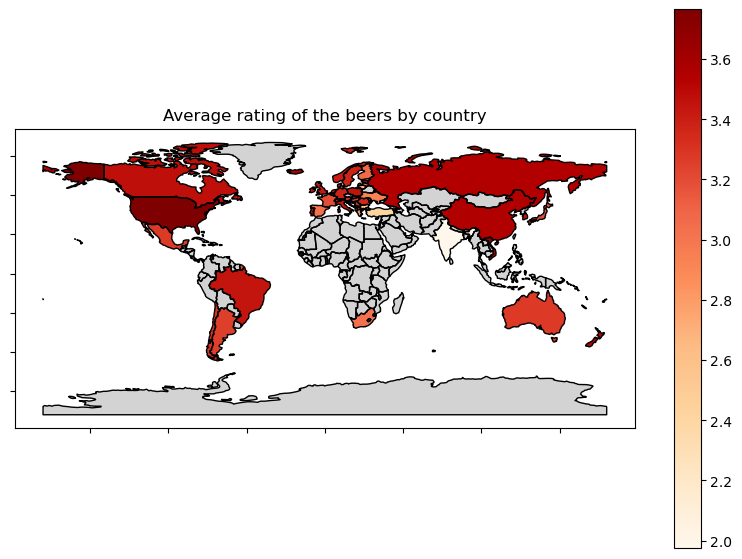

In [14]:
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the average ratings
world = world.merge(avg_ratings, left_on="name", right_on="brewery_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="avg_rating", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Average rating of the beers by country")
plt.show()

Notice how most beers are from the US or Europe, so we will plot only these two regions

In [15]:
# Print the countries with highest number of beers
num_unique_beers = num_unique_beers.sort_values(by="num_unique_beers", ascending=False)
num_unique_beers.head(20)

,brewery_location,num_unique_beers
102,"United States, California",3779
12,Canada,3237
27,England,2832
110,"United States, Illinois",1735
129,"United States, New York",1716
35,Germany,1548
6,Belgium,1473
89,Sweden,1346
135,"United States, Pennsylvania",1087
134,"United States, Oregon",1067


In [16]:
# Redoing the same but only for Europe and the US separately
united_states_ratings = country_ratings[country_ratings["brewery_location"].str.contains("United States")]

avg_US_ratings = united_states_ratings.groupby("brewery_location")["rating"].mean()
avg_US_ratings = avg_US_ratings.to_frame().reset_index()
avg_US_ratings.columns = ["brewery_location", "avg_rating"]

names_states = avg_US_ratings["brewery_location"].unique()
# From each name remove "Unites Sates, "
names_states = [name.replace("United States, ", "") for name in names_states]
avg_US_ratings["brewery_location"] = names_states

# Load map from file
us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")

us_map = us_map.merge(avg_US_ratings, left_on="NAME", right_on="brewery_location", how="right")


# For display purposes, move Alaska and Hawaii to the East
alaska = us_map[us_map["NAME"] == "Alaska"].geometry
hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

# Shift Alaska to the right
alaska = alaska.translate(xoff=40)
hawaii = hawaii.translate(xoff=40)

us_map_shifted = us_map.copy()
us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii

In [17]:
europe_map = world[world["continent"] == "Europe"]

europe_map.merge(avg_ratings, left_on="name", right_on="brewery_location", how="left")

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,brewery_location_x,avg_rating_x,brewery_location_y,avg_rating_y
0,144373535.0,Europe,Russia,RUS,1699876,"MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...",Russia,3.546870,Russia,3.546870
1,5347896.0,Europe,Norway,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",Norway,3.395852,Norway,3.395852
2,67059887.0,Europe,France,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",France,3.195971,France,3.195971
3,10285453.0,Europe,Sweden,SWE,530883,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",Sweden,3.368631,Sweden,3.368631
4,9466856.0,Europe,Belarus,BLR,63080,"POLYGON ((28.17671 56.16913, 29.22951 55.91834...",NaN,NaN,NaN,NaN
5,44385155.0,Europe,Ukraine,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",Ukraine,2.926926,Ukraine,2.926926
6,37970874.0,Europe,Poland,POL,595858,"POLYGON ((23.48413 53.91250, 23.52754 53.47012...",Poland,3.454857,Poland,3.454857
7,8877067.0,Europe,Austria,AUT,445075,"POLYGON ((16.97967 48.12350, 16.90375 47.71487...",Austria,3.309164,Austria,3.309164
8,9769949.0,Europe,Hungary,HUN,163469,"POLYGON ((22.08561 48.42226, 22.64082 48.15024...",Hungary,3.239650,Hungary,3.239650
9,2657637.0,Europe,Moldova,MDA,11968,"POLYGON ((26.61934 48.22073, 26.85782 48.36821...",Moldova,2.891360,Moldova,2.891360


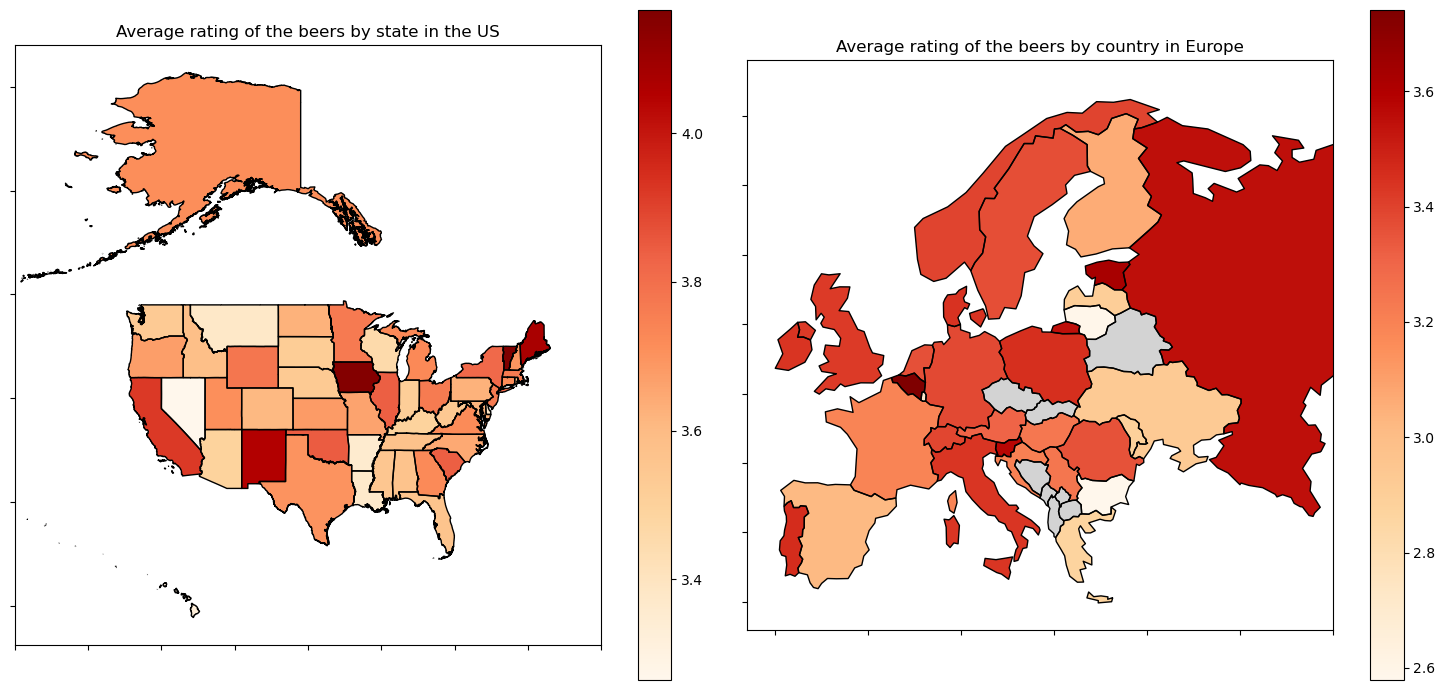

In [18]:
# Plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

us_map_shifted.boundary.plot(ax=ax[0], linewidth=1, color="black")
us_map_shifted.plot(column="avg_rating", ax=ax[0], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim(-140, -60)
ax[0].set_title("Average rating of the beers by state in the US")


europe_map.boundary.plot(ax=ax[1], linewidth=1, color="black")
europe_map.plot(column="avg_rating", ax=ax[1], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlim(-13, 50)
ax[1].set_ylim(33, 74)
ax[1].set_title("Average rating of the beers by country in Europe")

plt.tight_layout()
plt.show()

## 3) Second analysis : how users from one country rate beers

### Data cleaning

Remove any users with < 10 reviews, then aggregate by country, then remove any countries with < 10 users

le 10 c'est un peu arbitraire, mais c'est pour éviter d'avoir des pays avec 1 ou 2 users qui ont mis 5 étoiles à une bière et donc qui faussent les moyennes

In [115]:
users_ratings = reviews_df.copy()

#Total number of users that have rated at least one beer
print("Initial number of unique users: ", len(users_ratings["user_id"].unique()))

#Total number of ratings given by users that have rated at least 10 beers
filtered_users_ratings = users_ratings.drop(users_ratings[users_ratings["user_nbr_ratings"]<10].index)
print("Final number of unique users after filtering: ", len(filtered_users_ratings["user_id"].unique()))


Initial number of unique users:  92113
Final number of unique users after filtering:  57409


In [116]:
#Total number of users locations with at least one user
print("Initial number of unique user locations: ", len(users_ratings["user_location"].unique()))

#Compute the total number of users per user location
unique_users_location = filtered_users_ratings.drop_duplicates(subset=["user_name"])
filtered_users_location = unique_users_location.groupby("user_location").agg(
    {"user_name": "count"}
).rename(columns={"user_name": "nbr_users"})

#Total number of users locations that have more than 10 users
filtered_users_location = filtered_users_location[filtered_users_location["nbr_users"] >= 10].sort_values(by="nbr_users", ascending=False)
filtered_users_location = filtered_users_location.reset_index()
final_filtered_users = filtered_users_ratings[filtered_users_ratings["user_location"].isin(filtered_users_location["user_location"])]
print("Final number of unique user locations after filtering: ", len(final_filtered_users["user_location"].unique()))

Initial number of unique user locations:  198
Final number of unique user locations after filtering:  107


In [117]:
##TEST
# check if 'Afghanistan' (user location), that only had 1 user (user_id), had been well removed from the initial dataframe
'Afghanistan' in final_filtered_users['user_location'].values

False

In [118]:
print("Initial number of reviews: ", len(users_ratings))
print("Final number of reviews: ", len(final_filtered_users))
print("Percentage of reviews kept: {:.2f}%".format(len(final_filtered_users) / len(users_ratings) * 100))

Initial number of reviews:  1976606
Final number of reviews:  1816244
Percentage of reviews kept: 91.89%


In [119]:
final_filtered_users.head()

,beer_name,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,...,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings
0,Legbiter,19827,English Pale Ale,1417431600,Hellpop65,hellpop65.48993,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",2326.0
2,Legbiter,19827,English Pale Ale,1393412400,RochefortChris,rochefortchris.697017,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, North Carolina",1866.0
4,Legbiter,19827,English Pale Ale,1390647600,jaydoc,jaydoc.265507,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Kansas",9987.0
5,Legbiter,19827,English Pale Ale,1380794400,ejimhof,ejimhof.5743,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, Pennsylvania",4078.0
6,Legbiter,19827,English Pale Ale,1366884000,GraduatedCashew,graduatedcashew.730089,nan,nan,nan,nan,...,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,"United States, California",2329.0


In [120]:
'Anctartica' in final_filtered_users['user_location'].values

False

### Analysis

Compute some averages for countries, plot them, say there are some diff so we want to investigate
Potentially also wordclouds, here because we explained the dataset in part 2, just say "we gonna do the same"

In [121]:
users_beers = final_filtered_users.copy()

In [122]:
users_name_rating = users_beers.groupby('user_location').agg(
    {"user_name": "count",
     "beer_avg_rating_ba_rb": "mean"}).rename(columns={"user_name": "nbr_users", "beer_avg_rating_ba_rb": "avg_rating"})
users_name_rating = users_name_rating.reset_index()
users_name_rating.head()

,user_location,nbr_users,avg_rating
0,Aotearoa,51,3.403685
1,Argentina,55,3.573264
2,Australia,18708,3.396380
3,Austria,2359,3.429830
4,Belgium,23460,3.470421


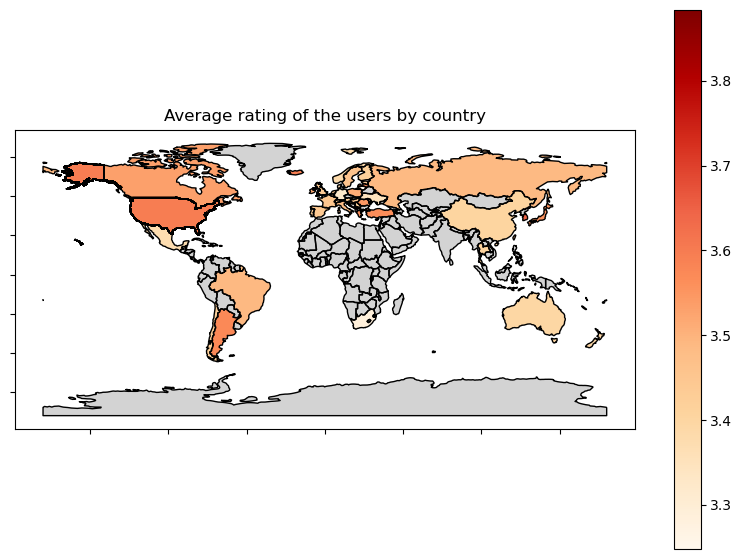

In [123]:
users_average_rating = users_name_rating.copy()

users_average_rating.loc[users_average_rating["user_location"].str.contains("United States"), "user_location"] = "United States of America"
users_average_rating.loc[users_average_rating["user_location"].str.contains("England"), "user_location"] = "United Kingdom"
users_average_rating.loc[users_average_rating["user_location"].str.contains("Scotland"), "user_location"] = "United Kingdom"
users_average_rating.loc[users_average_rating["user_location"].str.contains("Wales"), "user_location"] = "United Kingdom"
users_average_rating.loc[users_average_rating["user_location"].str.contains("Northern Ireland"), "user_location"] = "United Kingdom"

#Plot 
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the average ratings
world = world.merge(users_average_rating, left_on="name", right_on="user_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="avg_rating", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Average rating of the users by country")
plt.show()


In [124]:
users_name_rating.sort_values(by="nbr_users", ascending=False).head(20)


,user_location,nbr_users,avg_rating
60,"United States, California",122116,3.792182
6,Canada,116346,3.532655
93,"United States, Pennsylvania",93766,3.730749
68,"United States, Illinois",87375,3.783682
87,"United States, New York",79280,3.803990
12,Denmark,73940,3.384505
98,"United States, Texas",63263,3.700941
14,England,63009,3.435270
76,"United States, Massachusetts",58914,3.862310
50,Sweden,53154,3.459103


In [127]:
#Plot the same for Europe and US
users_us = users_name_rating[users_name_rating['user_location'].str.contains("United States")]

names_states = users_us['user_location'].unique()
# From each name remove "Unites Sates, "
names_states = [name.replace("United States, ", "") for name in names_states]
users_us['user_location'] = names_states

# Load map from file
us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")

us_map = us_map.merge(users_us, left_on="NAME", right_on="user_location", how="right")

# For display purposes, move Alaska and Hawaii to the East
alaska = us_map[us_map["NAME"] == "Alaska"].geometry
hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

# Shift Alaska to the right
alaska = alaska.translate(xoff=40)
hawaii = hawaii.translate(xoff=40)

us_map_shifted = us_map.copy()
us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii


/var/folders/l6/xlxb5g75383frbl9qkkpxhxh0000gn/T/ipykernel_34414/1516610157.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_us['user_location'] = names_states


In [130]:
europe_map = world[world["continent"] == "Europe"]

europe_map.merge(users_name_rating, left_on="name", right_on="user_location", how="left")

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,user_location_x,nbr_users_x,avg_rating_x,user_location_y,nbr_users_y,avg_rating_y
0,144373535.0,Europe,Russia,RUS,1699876,"MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...",Russia,1914.0,3.487705,Russia,1914.0,3.487705
1,5347896.0,Europe,Norway,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",Norway,29662.0,3.380190,Norway,29662.0,3.380190
2,67059887.0,Europe,France,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",France,6183.0,3.453835,France,6183.0,3.453835
3,10285453.0,Europe,Sweden,SWE,530883,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",Sweden,53154.0,3.459103,Sweden,53154.0,3.459103
4,9466856.0,Europe,Belarus,BLR,63080,"POLYGON ((28.17671 56.16913, 29.22951 55.91834...",NaN,NaN,NaN,NaN,NaN,NaN
5,44385155.0,Europe,Ukraine,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",Ukraine,406.0,3.345935,Ukraine,406.0,3.345935
6,37970874.0,Europe,Poland,POL,595858,"POLYGON ((23.48413 53.91250, 23.52754 53.47012...",Poland,21106.0,3.511460,Poland,21106.0,3.511460
7,8877067.0,Europe,Austria,AUT,445075,"POLYGON ((16.97967 48.12350, 16.90375 47.71487...",Austria,2359.0,3.429830,Austria,2359.0,3.429830
8,9769949.0,Europe,Hungary,HUN,163469,"POLYGON ((22.08561 48.42226, 22.64082 48.15024...",Hungary,2849.0,3.442402,Hungary,2849.0,3.442402
9,2657637.0,Europe,Moldova,MDA,11968,"POLYGON ((26.61934 48.22073, 26.85782 48.36821...",Moldova,705.0,3.400495,Moldova,705.0,3.400495


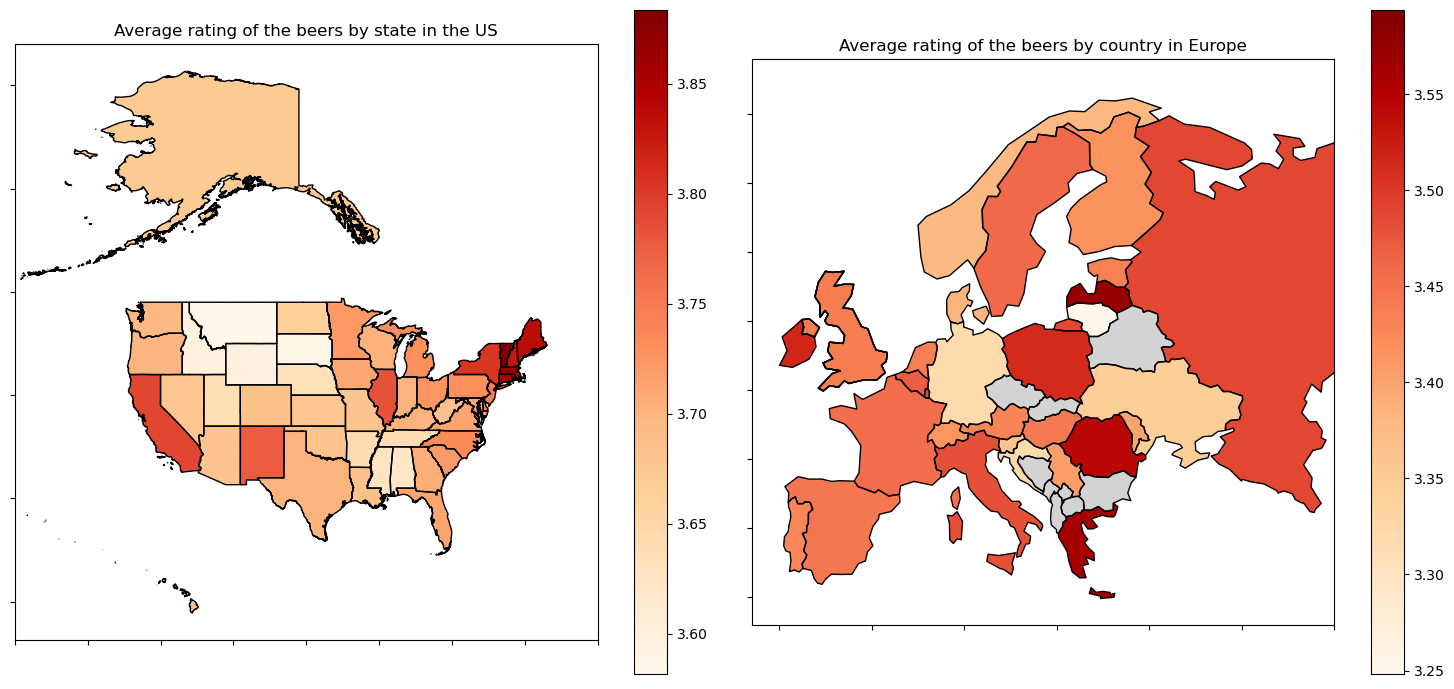

In [131]:
# Plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

us_map_shifted.boundary.plot(ax=ax[0], linewidth=1, color="black")
us_map_shifted.plot(column="avg_rating", ax=ax[0], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim(-140, -60)
ax[0].set_title("Average rating of the beers by state in the US")


europe_map.boundary.plot(ax=ax[1], linewidth=1, color="black")
europe_map.plot(column="avg_rating", ax=ax[1], legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlim(-13, 50)
ax[1].set_ylim(33, 74)
ax[1].set_title("Average rating of the beers by country in Europe")

plt.tight_layout()
plt.show()

In [132]:
users_average_rating.head()

,user_location,nbr_users,avg_rating
0,Aotearoa,51,3.403685
1,Argentina,55,3.573264
2,Australia,18708,3.396380
3,Austria,2359,3.429830
4,Belgium,23460,3.470421


In [136]:

#for each country compute the total number of users
users_per_country = users_average_rating.groupby("user_location").agg({"nbr_users": "sum"}).sort_values(by="nbr_users", ascending=False).head(20)
users_per_country = users_per_country.reset_index()

#compute the total number of users
total_users = users_per_country["nbr_users"].sum()

#add a column percentage of users
users_per_country["percentage_users"] = users_per_country["nbr_users"] / total_users * 100

users_per_country.head()


,user_location,nbr_users,percentage_users
0,United States of America,1206944,68.019531
1,Canada,116346,6.556891
2,United Kingdom,80429,4.532723
3,Denmark,73940,4.167024
4,Sweden,53154,2.995591


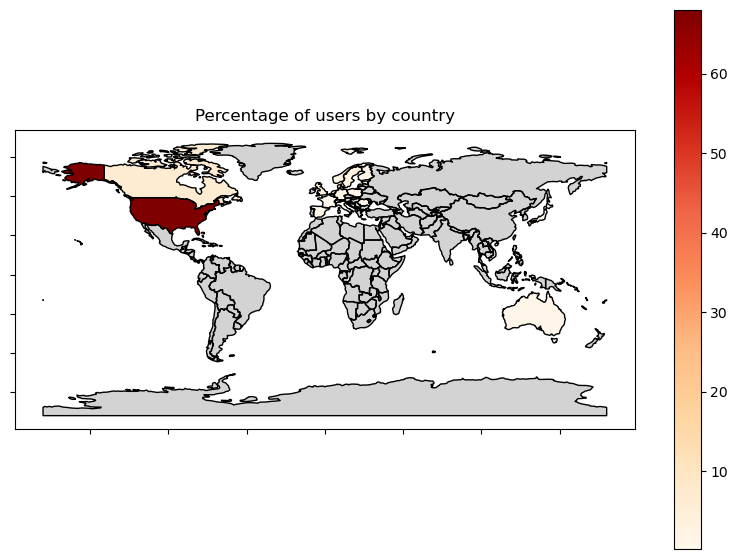

In [135]:
# Get a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the average ratings
world = world.merge(users_per_country, left_on="name", right_on="user_location", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="percentage_users", ax=ax, legend=True, cmap="OrRd", missing_kwds={"color": "lightgrey"})
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Percentage of users by country")
plt.show()